#CM1

# Dataset 1 : DKMA-Covid19-Jan-States

#Preprocessing

Preprocessign the data (outlier removal, feature selection, normalization, train-test split, creating 3 different training sets for the 3 targets, etc.)

In the end, we use the min-max normalization to train our deep learning models.

To be more specific, we did the following: converting string features to intigers, pushing labels at the end of the columns, checking for missing data, droping unnecessary features and features that create bias in our classification like state id and state name, converting bolean values to 0 or 1 in labels, removing outliers by grouping each state and detecting anomalies in each group by LOF, normalization, train-validation split in a way that our training data doesn't include some states as this is also true for the kaggle competition, and finally decomposing data into seperate labels.



In [22]:
# Preprocessing the data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('dkmacovid_train.csv')

number_of_rows, _ = df.shape


splitted_val = int(''.join(df.iloc[0,-7].split(',')))
splitted_val

df_fixed = df['Resident Population 2020 Census'].apply(lambda x: int(''.join(x.split(','))))
dropped = df.drop(columns='Resident Population 2020 Census')
dropped['Resident Population 2020 Census'] = df_fixed
df = dropped.copy()

df_fixed_2 = df['Population Density 2020 Census'].apply(lambda x: float(''.join(x.split(','))))
dropped = df.drop(columns='Population Density 2020 Census')
dropped['Population Density 2020 Census'] = df_fixed_2
df = dropped.copy()
df.dtypes

temp = df.drop(columns=['Confirmed', 'Deaths', 'Recovered'])
temp['Confirmed'] = df['Confirmed']
temp['Deaths'] = df['Deaths']
temp['Recovered'] = df['Recovered']

df = temp.copy()
df.dtypes

sums = df.loc[:,list(df.columns)].isnull().sum() 
binary_sums = sums > 0
print("Number of missed values: {} which is {} of data".format(sums.sum(), (sums.sum() / number_of_rows).round(2)))
print("Description: \n{}".format(sums[binary_sums]))

df = df.drop(columns=['Testing_Rate'])

df.Deaths = df.Deaths.replace({False: 0, True: 1})
df.Recovered = df.Recovered.replace({False: 0, True: 1})
df.Confirmed = df.Confirmed.replace({False: 0, True: 1})

dfs_grouped = []

for i in range(52):
  df_group = df[(df["State ID"] == i)]
  if df_group.shape[0] > 0:
    dfs_grouped.append(df_group)

dfs_grouped[0:2]

num_samples = 30
count = np.zeros(len(list(df.columns[3:-3])))
features = list(df.columns[3:-3])
print(features)

for each_state in dfs_grouped:
  s = 0 
  count = np.zeros(len(list(df.columns[3:-3])))

  for j in features:
    for i in range(num_samples):
      if each_state[j].iloc[i] > each_state[j].mean() + 3*each_state[j].std():
          each_state[j].iloc[i] = each_state[j].mean() + 3*each_state[j].std()
          count[s] += 1 #count represents the number of outliers in each feature
      elif each_state[j].iloc[i] < each_state[j].mean() - 3*each_state[j].std():
          each_state[j].iloc[i] = each_state[j].mean() - 3*each_state[j].std()
          count[s] += 1
    s += 1
  #print ('The number of outliers in {0} ={1}'.format(j, count[s]))



# for i in range(len(dfs_grouped)):
#   if dfs_grouped[i]["State"].iloc[0] == "Nebraska":
#     print(i)

df_merged = dfs_grouped[0]
flag = True

for dfs in dfs_grouped:
  if flag:
    flag = False
    continue
  else: 
    df_merged = df_merged.append(dfs)


df = df_merged.sample(frac=1).reset_index(drop=True)

df_test = df[(df["State ID"] == 1) | (df["State ID"] == 4) | (df["State ID"] == 47) | (df["State ID"] == 30)
 | (df["State ID"] == 25) | (df["State ID"] == 22) | 
 (df["State ID"] == 12) | (df["State ID"] == 50) |
 (df["State ID"] == 20) | (df["State ID"] == 13) ]

index_names = df[(df["State ID"] == 1) | (df["State ID"] == 4) | (df["State ID"] == 47) | (df["State ID"] == 30)
 | (df["State ID"] == 25) | (df["State ID"] == 22) | 
 (df["State ID"] == 12) | (df["State ID"] == 50) |
 (df["State ID"] == 20) | (df["State ID"] == 13) ].index

df_train = df.drop(index_names).drop(columns=["State ID","Day","State"])

df_test = df_test.drop(columns=["State ID","Day","State"])

df_train_dropped = df.drop(index_names).loc[:,["Day", "State ID", "State"]]

df_train_groups = df.drop(index_names)["State ID"]

training_group_numbers = len(np.unique(df_train_groups.to_numpy()))


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

attributes = df_train.columns[0:-3]
df_standard_train = df_train.copy()
df_standard_test = df_test.copy()
for i in attributes:
    scale = StandardScaler().fit(df_train[[i]])
    scale2 = StandardScaler().fit(df_test[[i]])

    df_standard_train[i] = scale.transform(df_train[[i]])
    df_standard_test[i] = scale.transform(df_test[[i]])

df_standard_trainZscore = df_standard_train.copy()
df_standard_testZscore = df_standard_test.copy()

df_standard_trainZscore


attributes = df_train.columns[0:-3]
df_standard_train = df_train.copy()
df_standard_test = df_test.copy()

for i in attributes:
    scale = MinMaxScaler().fit(df_train[[i]])
    scale2 = MinMaxScaler().fit(df_test[[i]])

    df_standard_train[i] = scale.transform(df_train[[i]])
    df_standard_test[i] = scale.transform(df_test[[i]])

df_standard_trainMinMax = df_standard_train.copy()
df_standard_testMinMax = df_standard_test.copy()

df_dict = {'method': 'normalized', 'data': [df_standard_trainMinMax, df_standard_testMinMax]}
omLabels = {'Confirmed': [], 'Deaths': [], 'Recovered': []}


df_onlyConfirmed_train = df_dict['data'][0].drop(columns=['Deaths', 'Recovered'])
df_onlyConfirmed_test = df_dict['data'][1].drop(columns=['Deaths', 'Recovered'])

df_onlyRecovered_train = df_dict['data'][0].drop(columns=['Deaths', 'Confirmed'])
df_onlyRecovered_test = df_dict['data'][1].drop(columns=['Deaths', 'Confirmed'])

df_onlyDeaths_train = df_dict['data'][0].drop(columns=['Confirmed', 'Recovered'])
df_onlyDeaths_test = df_dict['data'][1].drop(columns=['Confirmed', 'Recovered'])





Number of missed values: 0 which is 0.0 of data
Description: 
Series([], dtype: int64)
['Lat', 'Long_', 'Active', 'Incident_Rate', 'Total_Test_Results', 'Case_Fatality_Ratio', 'Density Rank 2020 Census', 'SexRatio', 'Resident Population 2020 Census', 'Population Density 2020 Census']


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#CM2

In this part, we implemented the suggested default fully connected architecture using the keras library. 

We train three models, one for each target (confirmed, recovered, and deaths) as it works better than training a single model to predict the total output.

As you can see below, we use 5-fold cross validation to evaluate different choices of batch_size, and different optimization functions (Adam, SGD, etc.) and different values for the learning rate (1e-6 to 1e-2) to reach the best possible result for this default architecture. In the end,  adam with learning rate of 1e-3 and batch_size=128 worked best for all the 3 models. We also applying class-weights in training based on the frequency of each value of each label.

we apply class weights to avoid bias in our classification.

In [10]:
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import time
import copy
from keras.regularizers import l2




# Confirmed Output

In [ ]:
df = copy.copy(df_onlyConfirmed_train)
labels = df['Confirmed']
df.drop('Confirmed', inplace=True, axis=1)

x_train = df.to_numpy()
y_train = labels.to_numpy()

df = copy.copy(df_onlyConfirmed_test)
labels = df['Confirmed']
df.drop('Confirmed', inplace=True, axis=1)

x_test = df.to_numpy()
y_test = labels.to_numpy()



keras.backend.clear_session()

model = models.Sequential()




# Input & Hidden - Layer

model.add(layers.Dense(20,activation='relu',input_shape=(10,)))
model.add(layers.Dense(20,activation='relu'))
# Output- Layer

model.add(layers.Dense(1, activation = 'softmax'))

model.summary()

# compiling the model

#sgd=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
op = keras.optimizers.Adam(learning_rate=0.001)
loss_ce = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer = op, loss = loss_ce,

              metrics = ["accuracy"])





batch_size = 128

epochs = 20

class_weight = {0: 46.0,
                1: 1034.0}



from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)


accuracy = 0

for train_index, val_index in kfold.split(x_train):
  X_train, X_validation = x_train[train_index], x_train[val_index]
  Y_train, Y_validation = y_train[train_index], y_train[val_index]

  results= model.fit(X_train, Y_train, batch_size=128, epochs=epochs, class_weight=class_weight, verbose=0)

  y_pred = model.predict(X_validation)

  accuracy = accuracy + accuracy_score(Y_validation,y_pred)




accuracy = accuracy/5



start_time = time.time()
results_default_confirmed= model.fit(x_train, y_train,

                    batch_size=128,

                    epochs=epochs, class_weight=class_weight, validation_data=(x_test, y_test))

print("--- Average cross-validation accuracy: %s ---"%accuracy)
deep_traintime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_traintime)

start_time = time.time()

y_pred = model.predict(x_test)

deep_testtime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_testtime)

accuracy = accuracy_score(y_test,y_pred)
print("--- Test accuracy: %s ---"%accuracy)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
9/9 [==============================] - 0s 39ms/step - loss: 151.2018 - accuracy: 0.9574 - val_loss: 0.1116 - val_accuracy: 0.9833
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 150.8655 - accuracy: 0.9574 - val_loss: 0.1098 - val_accuracy: 0.9833
Epoch 3/20
9/9 [==============================] - 0s 4ms/step - loss: 150.8259 - accuracy: 0.9574 - val_los

As you can see in the above, our default model for the "Confimed" output has   0.957 average cross-validation accuracy, and its training time was 1.337 seconds and its testing time was x1 and reached test accuracy of 0.983.

# Recovered Output



In [ ]:
df = copy.copy(df_onlyRecovered_train)
labels = df['Recovered']
df.drop('Recovered', inplace=True, axis=1)

x_train = df.to_numpy()
y_train = labels.to_numpy()

df = copy.copy(df_onlyRecovered_test)
labels = df['Recovered']
df.drop('Recovered', inplace=True, axis=1)

x_test = df.to_numpy()
y_test = labels.to_numpy()



keras.backend.clear_session()

model = models.Sequential()




# Input & Hidden - Layer

model.add(layers.Dense(20,activation='relu',input_shape=(10,)))
model.add(layers.Dense(20,activation='relu'))
# Output- Layer

model.add(layers.Dense(1, activation = 'softmax'))

model.summary()

# compiling the model

#sgd=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
op = keras.optimizers.Adam(learning_rate=0.001)
loss_ce = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer = op, loss = loss_ce,

              metrics = ["accuracy"])





batch_size = 128

epochs = 20

class_weight = {0: 401.0,
                1: 679.0}



from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)


accuracy = 0

for train_index, val_index in kfold.split(x_train):
  X_train, X_validation = x_train[train_index], x_train[val_index]
  Y_train, Y_validation = y_train[train_index], y_train[val_index]

  results= model.fit(X_train, Y_train, batch_size=128, epochs=epochs, class_weight=class_weight, verbose=0)

  y_pred = model.predict(X_validation)

  accuracy = accuracy + accuracy_score(Y_validation,y_pred)




accuracy = accuracy/5



start_time = time.time()
results_default_recovered= model.fit(x_train, y_train,

                    batch_size=128,

                    epochs=epochs, class_weight=class_weight, validation_data=(x_test, y_test))


print("--- Average cross-validation accuracy: %s ---"%accuracy)
deep_traintime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_traintime)

start_time = time.time()
y_pred = model.predict(x_test)

deep_testtime = (time.time() - start_time)
print("--- Testing Time %s seconds ---" % deep_testtime)

print(np.unique(y_pred, return_counts=True))
accuracy = accuracy_score(y_test,y_pred)
print("--- Test accuracy: %s ---"%accuracy)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
9/9 [==============================] - 0s 39ms/step - loss: 218.2730 - accuracy: 0.6287 - val_loss: 0.4319 - val_accuracy: 0.6167
Epoch 2/20
9/9 [==============================] - 0s 4ms/step - loss: 217.6006 - accuracy: 0.6287 - val_loss: 0.4313 - val_accuracy: 0.6167
Epoch 3/20
9/9 [==============================] - 0s 4ms/step - loss: 216.5391 - accuracy: 0.6287 - val_los

As you can see in the above, our default model for the "Recovered" output has 0.629 average cross-validation accuracy, and its training time was 1.317 seconds and its testing time was 0.053 seconds and reached test accuracy of 0.617.

# Deaths Output

In [ ]:
df = copy.copy(df_onlyDeaths_train)
labels = df['Deaths']
df.drop('Deaths', inplace=True, axis=1)

x_train = df.to_numpy()
y_train = labels.to_numpy()

df = copy.copy(df_onlyDeaths_test)
labels = df['Deaths']
df.drop('Deaths', inplace=True, axis=1)

x_test = df.to_numpy()
y_test = labels.to_numpy()



keras.backend.clear_session()

model = models.Sequential()




# Input & Hidden - Layer

model.add(layers.Dense(20,activation='relu',input_shape=(10,)))
model.add(layers.Dense(20,activation='relu'))
# Output- Layer

model.add(layers.Dense(1, activation = 'softmax'))

model.summary()

# compiling the model

#sgd=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
op = keras.optimizers.Adam(learning_rate=0.001)
loss_ce = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer = op, loss = loss_ce,

              metrics = ["accuracy"])





batch_size = 128

epochs = 20

class_weight = {0: 111.0,
                1: 969.0}



from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

accuracy = 0

for train_index, val_index in kfold.split(x_train):
  X_train, X_validation = x_train[train_index], x_train[val_index]
  Y_train, Y_validation = y_train[train_index], y_train[val_index]

  results= model.fit(X_train, Y_train, batch_size=128, epochs=epochs, class_weight=class_weight, verbose=0)

  y_pred = model.predict(X_validation)

  accuracy = accuracy + accuracy_score(Y_validation,y_pred)




accuracy = accuracy/5



start_time = time.time()
results_default_deaths= model.fit(x_train, y_train,

                    batch_size=128,

                    epochs=epochs, class_weight=class_weight, validation_data=(x_test, y_test))

print("--- Average cross-validation accuracy: %s ---"%accuracy)
deep_traintime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_traintime)

start_time = time.time()

y_pred = model.predict(x_test)

deep_testtime = (time.time() - start_time)
print("--- Testing Time %s seconds ---" % deep_testtime)


print(np.unique(y_pred, return_counts=True))
accuracy = accuracy_score(y_test,y_pred)
print("--- Test accuracy: %s ---"%accuracy)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
9/9 [==============================] - 0s 36ms/step - loss: 218.9558 - accuracy: 0.8972 - val_loss: 0.2608 - val_accuracy: 0.9167
Epoch 2/20
9/9 [==============================] - 0s 4ms/step - loss: 219.2648 - accuracy: 0.8972 - val_loss: 0.2597 - val_accuracy: 0.9167
Epoch 3/20
9/9 [==============================] - 0s 4ms/step - loss: 219.3333 - accuracy: 0.8972 - val_los

As you can see in the above, our default model for the "Deaths" output has 0.897 average cross-validation accuracy, and its training time was 1.15 seconds and its testing time was 0.050 seconds and reached test accuracy of 0.917.

#CM3

For our own architecture, we cannot use the Resnet architectures because they include convolutional layers, but our data is non-image and there are no spatial correlation in our data features. 

In this section, we present two approaches. First a "Deeper Network" and then an "LSTM Network" since each of our target has a correlation with the past samples too, and there is a sort of time order in our training and testing datasets. 

In this part, since our final goal is to obtain the best accuracy for the kaggle competition, we treat the test dataset obtained from the original labeled data as the validation set and don't do cross-validation on the training data anymore.

Moreover, we still train one model for each output in this part.

# First Approch: Deeper Network with Regularizer

We first try to improve the model by adding a few more hidden layers and L2 regularizer after each Relu activation function. Moreover, we use droupout and batch normalization to improve the models' generalization. Also, sigmoid activation function for the output layer improved our validation accuracy for the Recovered output. After evaluationg different values of hyper-parameters with 5-fold cross-validation, we end up using batch_size = 128 and Adam optimizer with learning rate = 1e-4. Our architecture now has 5 hidden layers with 50 nodes each and Relu as activation function that every layer has a droupout=0.4 (0.5 for some outputs) and l2_regularizer=0.4 (tuned by the 5-fold cross-validation). Our output layer activation function is sigmoid now. 

As before, we apply class weights to avoid bias in our classification.

# Confirmed Output

In [23]:
df = copy.copy(df_onlyConfirmed_train)
labels = df['Confirmed']
df.drop('Confirmed', inplace=True, axis=1)

x_train = df.to_numpy()
y_train = labels.to_numpy()

df = copy.copy(df_onlyConfirmed_test)
labels = df['Confirmed']
df.drop('Confirmed', inplace=True, axis=1)

x_test = df.to_numpy()
y_test = labels.to_numpy()



keras.backend.clear_session()

model = models.Sequential()


dropout_rate=0.4
l2_regularizer=0.4

# Input & Hidden - Layer

model.add(layers.Dense(50,activation='relu',input_shape=(10,), activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))
# Output- Layer

model.add(layers.Dense(1, activation = 'sigmoid', activity_regularizer=l2(l2_regularizer)))

model.summary()

# compiling the model

#sgd=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
op = keras.optimizers.Adam(learning_rate=0.001)
loss_ce = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer = op, loss = loss_ce,

              metrics = ["accuracy"])





batch_size = 128

epochs = 10

class_weight = {0: 46.0,
                1: 1034.0}



from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

start_time = time.time()
accuracy = 0

# for train_index, val_index in kfold.split(x_train):
#   X_train, X_validation = x_train[train_index], x_train[val_index]
#   Y_train, Y_validation = y_train[train_index], y_train[val_index]

#   results= model.fit(X_train, Y_train, batch_size=128, epochs=epochs, class_weight=class_weight)

#   y_pred = model.predict(X_validation)
#   thr = 0.8
#   y_pred[y_pred>thr] = 1
#   y_pred[y_pred<=thr] = 0

#   accuracy = accuracy + accuracy_score(Y_validation,y_pred)


# print("***********")
# deep_traintime = (time.time() - start_time)/5
# print("--- Average Training Time %s seconds ---" % deep_traintime)

# accuracy = accuracy/5
# print("--- Average cross-validation accuracy: %s ---"%accuracy)



results= model.fit(x_train, y_train,

                    batch_size=128,

                    epochs=epochs, class_weight=class_weight, verbose=0)


deep_traintime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_traintime)
y_pred = model.predict(x_test)
thr = 0.85
y_pred[y_pred>thr] = 1
y_pred[y_pred<=thr] = 0


accuracy = accuracy_score(y_test,y_pred)
print("--- Test accuracy: %s ---"%accuracy)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2

# Recovered Output

In [26]:
df = copy.copy(df_onlyRecovered_train)
labels = df['Recovered']
df.drop('Recovered', inplace=True, axis=1)

x_train = df.to_numpy()
y_train = labels.to_numpy()

df = copy.copy(df_onlyRecovered_test)
labels = df['Recovered']
df.drop('Recovered', inplace=True, axis=1)

x_test = df.to_numpy()
y_test = labels.to_numpy()



keras.backend.clear_session()

model = models.Sequential()


dropout_rate=0.4
l2_regularizer=0.4

# Input & Hidden - Layer

model.add(layers.Dense(50,activation='relu',input_shape=(10,), activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

# Output- Layer

model.add(layers.Dense(1, activation = 'sigmoid', activity_regularizer=l2(l2_regularizer)))

model.summary()

# compiling the model

#op = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
op = keras.optimizers.Adam(learning_rate=0.0001)
loss_ce = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer = op, loss = loss_ce,

              metrics = ["accuracy"])





batch_size = 128

epochs = 800

class_weight = {0: 401.0,
                1: 679.0}



from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

start_time = time.time()
accuracy = 0

# for train_index, val_index in kfold.split(x_train):
#   X_train, X_validation = x_train[train_index], x_train[val_index]
#   Y_train, Y_validation = y_train[train_index], y_train[val_index]

#   results= model.fit(X_train, Y_train, batch_size=128, epochs=epochs, class_weight=class_weight)

#   y_pred = model.predict(X_validation)

#   accuracy = accuracy + accuracy_score(Y_validation,y_pred)


# print("***********")
# deep_traintime = (time.time() - start_time)/5
# print("--- Average Training Time %s seconds ---" % deep_traintime)

# accuracy = accuracy/5
# print("--- Average cross-validation accuracy: %s ---"%accuracy)



results= model.fit(x_train, y_train,

                    batch_size=128,

                    epochs=epochs, class_weight=class_weight, verbose=0)



deep_traintime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_traintime)
y_pred = model.predict(x_test)
thr = 0.8
y_pred[y_pred>thr] = 1
y_pred[y_pred<=thr] = 0


accuracy = accuracy_score(y_test,y_pred)
print("--- Test accuracy: %s ---"%accuracy)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2

# Deaths Output

In [25]:
df = copy.copy(df_onlyDeaths_train)
labels = df['Deaths']
df.drop('Deaths', inplace=True, axis=1)

x_train = df.to_numpy()
y_train = labels.to_numpy()

df = copy.copy(df_onlyDeaths_test)
labels = df['Deaths']
df.drop('Deaths', inplace=True, axis=1)

x_test = df.to_numpy()
y_test = labels.to_numpy()



keras.backend.clear_session()

model = models.Sequential()


dropout_rate=0.6
l2_regularizer=0.4

# Input & Hidden - Layer

model.add(layers.Dense(50,activation='relu',input_shape=(10,), activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(50,activation='relu', activity_regularizer=l2(l2_regularizer)))
model.add(layers.Dropout(dropout_rate))
# Output- Layer

model.add(layers.Dense(1, activation = 'softmax', activity_regularizer=l2(l2_regularizer)))

model.summary()

# compiling the model

#sgd=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
op = keras.optimizers.Adam(learning_rate=0.001)
loss_ce = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer = op, loss = loss_ce,

              metrics = ["accuracy"])





batch_size = 128

epochs = 50

class_weight = {0: 111.0,
                1: 969.0}



from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

start_time = time.time()
accuracy = 0





results= model.fit(x_train, y_train,

                    batch_size=128,

                    epochs=epochs, class_weight=class_weight, verbose=0)


deep_traintime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_traintime)
y_pred = model.predict(x_test)
thr = 0.6
y_pred[y_pred>thr] = 1
y_pred[y_pred<=thr] = 0


accuracy = accuracy_score(y_test,y_pred)
print("--- Test accuracy: %s ---"%accuracy)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2

# Second Approach: LSTM Network

As mentioned earlier, each of our target has a correlation with the past samples too, and there is a sort of time order in our training and testing datasets. Therefore, using an LSTM to capture these temporal dependencies could really help in the classification of the three outputs in this problem.

First of all, we need to convert the training data so that it includes a sequance of past samples for each label. We chose number of sequences to be 3 by trying and evaluating different values. So, we define a function called "split_sequences" that takes the training data with shape n*d and produces a data set with shape n*3*d that includes the last 3 samples for each label.

We use a stacked LSTM architecture with two LSTM layers with 50 nodes and Relu activation function, and a dense node as the output with sigmoid activation function. (our loss function as before is binary cross-entropy). After examinng different hyper-parameters, Adam with default parameters (learning_rate=0.001) were chosen to reach the best result in validation. 

For the "Recovered" output, we used a single LSTM network since it performed better than the staked LSTM. Because the number of features in our dataset is small (near 10) this could be expected. 

As before, we apply class weights to avoid bias in our classification. 

here is the model summary:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

lstm (LSTM)                  (None, 3, 50)             12200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        

Total params: 32,451
Trainable params: 32,451
Non-trainable params: 0

# Confirmed Output 

In [ ]:

from numpy import array
from numpy import hstack
import copy
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
df = copy.copy(df_onlyConfirmed_train)

dataset = df.to_numpy()

df = copy.copy(df_onlyConfirmed_test)

vakidation_dataset = df.to_numpy()


# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
X_test, Y_test = split_sequences(vakidation_dataset, n_steps)

n_features = X.shape[2]
loss_ce = tf.keras.losses.BinaryCrossentropy()
# define model
model_confirmed = Sequential()
model_confirmed.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_confirmed.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_confirmed.add(Dense(1,activation = 'sigmoid'))
model_confirmed.compile(optimizer='adam', loss=loss_ce, metrics = ["accuracy"])
class_weight = {0: 46.0,
                1: 1034.0}
model_confirmed.summary()
start_time = time.time()
# fit model
results_LSTM_confirmed = model_confirmed.fit(X, y, epochs=20, verbose=0 ,class_weight=class_weight, batch_size=32, validation_data=(X_test, Y_test))

deep_traintime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_traintime)

start_time = time.time()
yhat = model_confirmed.predict(X_test, verbose=0)

deep_testtime = (time.time() - start_time)
print("--- Testing Time %s seconds ---" % deep_testtime)

thr = 0.5
y_pred = copy.copy(yhat)
y_pred[y_pred>thr] = 1
y_pred[y_pred<=thr] = 0
accuracy = accuracy_score(Y_test,y_pred)
print("--- Test accuracy: %s ---"%accuracy)






--- Training Time 8.25221562385559 seconds ---
--- Testing Time 0.878211498260498 seconds ---
--- Test accuracy: 0.9832214765100671 ---


As you can see in the above, our LSTM model for the "Confirmed" output has: training time=8.25 seconds and its testing time was 0.878 seconds and reached test accuracy of 0.983.

#Recovered Output

In [ ]:

 
df = copy.copy(df_onlyRecovered_train)

dataset = df.to_numpy()

df = copy.copy(df_onlyRecovered_test)

vakidation_dataset = df.to_numpy()

# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
X_test, Y_test = split_sequences(vakidation_dataset, n_steps)

n_features = X.shape[2]
loss_ce = tf.keras.losses.BinaryCrossentropy()
# define model
model_recovered = Sequential()
#model_recovered.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_recovered.add(LSTM(50, activation='relu'))
model_recovered.add(Dense(1, activation = 'sigmoid'))
model_recovered.compile(optimizer='adam', loss=loss_ce, metrics = ["accuracy"])
class_weight = {0: 401.0,
                1: 679.0}
model_recovered.summary()
start_time = time.time()
# fit model
results_LSTM_recovered = model_recovered.fit(X, y, epochs=50, verbose=0, class_weight=class_weight, validation_data=(X_test, Y_test))

deep_traintime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_traintime)

start_time = time.time()
yhat = model_recovered.predict(X_test, verbose=0)

deep_testtime = (time.time() - start_time)
print("--- Testing Time %s seconds ---" % deep_testtime)

thr = 0.5
y_pred = copy.copy(yhat)
y_pred[y_pred>thr] = 1
y_pred[y_pred<=thr] = 0
accuracy = accuracy_score(Y_test,y_pred)
print("--- Test accuracy: %s ---"%accuracy)

--- Training Time 9.26669692993164 seconds ---
--- Testing Time 0.4712331295013428 seconds ---
--- Test accuracy: 0.7785234899328859 ---


As you can see in the above, our LSTM model for the "Recovered" output has: training time=9.26 seconds and its testing time was 0.47 seconds and reached test accuracy of 0.778.

#Deaths Output

In [ ]:
df = copy.copy(df_onlyDeaths_train)

dataset = df.to_numpy()

df = copy.copy(df_onlyDeaths_test)

vakidation_dataset = df.to_numpy()



n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
X_test, Y_test = split_sequences(vakidation_dataset, n_steps)

n_features = X.shape[2]
loss_ce = tf.keras.losses.BinaryCrossentropy()
# define model
model_deaths = Sequential()
model_deaths.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_deaths.add(Dense(1, activation = 'sigmoid'))
model_deaths.compile(optimizer='adam', loss=loss_ce, metrics = ["accuracy"])
class_weight = {0: 111.0,
                1: 969.0}

model_deaths.summary()
start_time = time.time()
# fit model
results_LSTM_deaths = model_deaths.fit(X, y, epochs=20, verbose=0, class_weight=class_weight, validation_data=(X_test, Y_test))

deep_traintime = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_traintime)

start_time = time.time()
yhat = model_deaths.predict(X_test, verbose=0)

deep_testtime = (time.time() - start_time)
print("--- Testing Time %s seconds ---" % deep_testtime)

thr = 0.4
y_pred = copy.copy(yhat)
y_pred[y_pred>thr] = 1
y_pred[y_pred<=thr] = 0
accuracy = accuracy_score(Y_test,y_pred)
print("--- Test accuracy: %s ---"%accuracy)

--- Training Time 7.251720190048218 seconds ---
--- Testing Time 0.5037727355957031 seconds ---
--- Test accuracy: 0.9161073825503355 ---


As you can see in the above, our LSTM model for the "Deaths" output has: training time=7.25 seconds and its testing time was 0.50 seconds and reached test accuracy of 0.916.

#CM4

In this part, we compare the results of the default network with the LSTM network (we chose LSTM approach as our final solution for the kaggle competition because it had the best performance) 


#Default Network: Confirmed Output

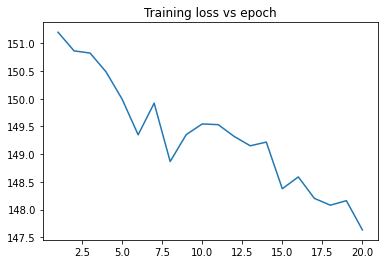

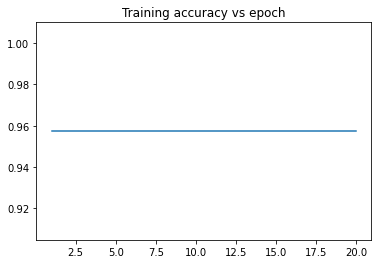

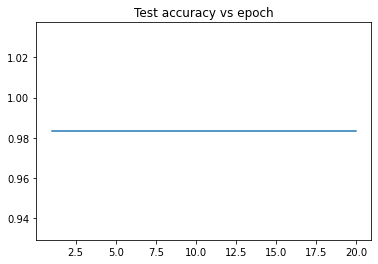

In [ ]:
Epochs = np.arange(1,20+1)

plt.figure()
plt.plot(Epochs, results_default_confirmed.history['loss'])
plt.title("Training loss vs epoch")
plt.show()

plt.figure()
plt.plot(Epochs, results_default_confirmed.history['accuracy'])
plt.title("Training accuracy vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_default_confirmed.history['val_accuracy'])
plt.title("Test accuracy vs epoch")
plt.show()


As you can see in the above, training loss decreases steadily with the number of epochs, but the decrease in training loss becomes very insignificant after epoch=20, so thats why we chose number of epochs to be 20. 

Training accuracy and testing accuracy are constant, that means our default model trains very fast and reaches good performance in small number of epochs for this target. 

As we calculated in CM2, our default model for the "Confimed" output has 0.957 average cross-validation accuracy, and its training time was 1.337 seconds and its testing time was x1 and reached test accuracy of 0.983.



# LSTM Network: Confirmed Output

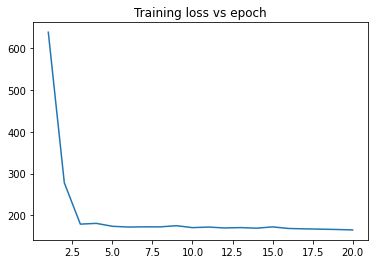

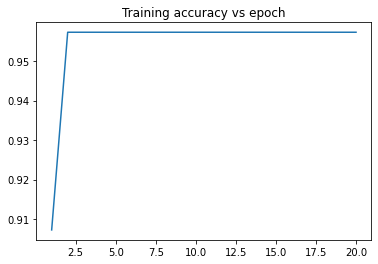

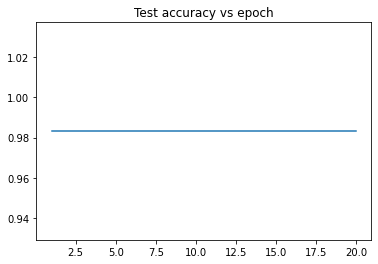

In [ ]:
Epochs = np.arange(1,20+1)

plt.figure()
plt.plot(Epochs, results_LSTM_confirmed.history['loss'])
plt.title("Training loss vs epoch")
plt.show()

plt.figure()
plt.plot(Epochs, results_LSTM_confirmed.history['accuracy'])
plt.title("Training accuracy vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_LSTM_confirmed.history['val_accuracy'])
plt.title("Test accuracy vs epoch")
plt.show()

As you can see in the above, training loss decreases  with the number of epochs, till epoch=5. 

Testing accuracy is constant, and training accuracy becomes constant after epoch=2. That means our default model trains very fast and reaches good performance in small number of epochs for this target. Therefore, we choose number of epochs to be 20.

As we calculated in CM3, our LSTM model for the "Confirmed" output has: training time=8.25 seconds and its testing time was 0.878 seconds and reached test accuracy of 0.983.

As we expected, the LSTM model has higher training time and testing time since it needs to be trained on sequence of samples and capture the temporal corelations in the data. We couldn't reach a higher test accuracy than the default model (0.98 is difficult to beat) but for the kaggle competition the output of LSTM model achieved much a better score than the default network.

#Default Network: Recovered Output

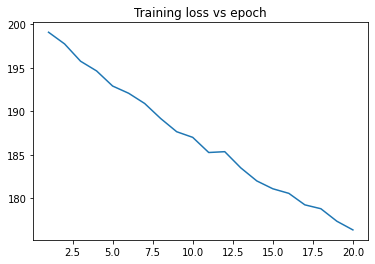

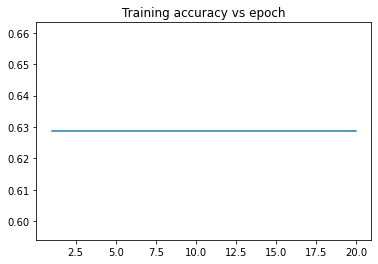

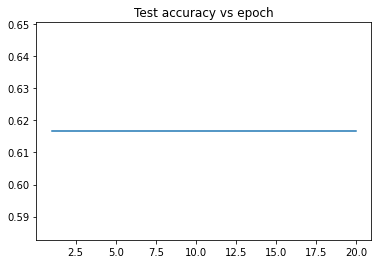

In [ ]:
Epochs = np.arange(1,20+1)

plt.figure()
plt.plot(Epochs, results_default_recovered.history['loss'])
plt.title("Training loss vs epoch")
plt.show()

plt.figure()
plt.plot(Epochs, results_default_recovered.history['accuracy'])
plt.title("Training accuracy vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_default_recovered.history['val_accuracy'])
plt.title("Test accuracy vs epoch")
plt.show()

As you can see in the above, training loss decreases steadily with the number of epochs, but the decrease in training loss becomes very insignificant after epoch=20, so thats why we chose number of epochs to be 20.

Training accuracy and testing accuracy are constant, that means our default model trains very fast and reaches good performance in small number of epochs for this target.

As we calculated in CM2, our default model for the "Recovered" output has 0.629 average cross-validation accuracy, and its training time was 1.317 seconds and its testing time was 0.053 seconds and reached test accuracy of 0.617.

# LSTM Network: Recovered Output

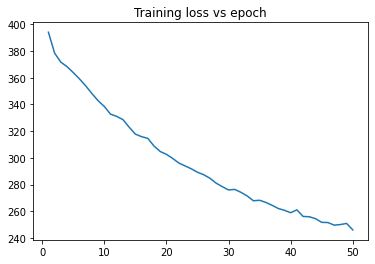

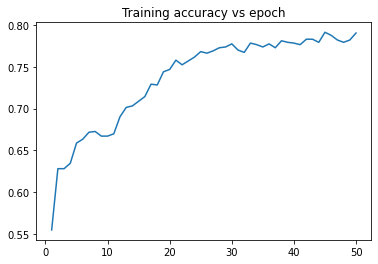

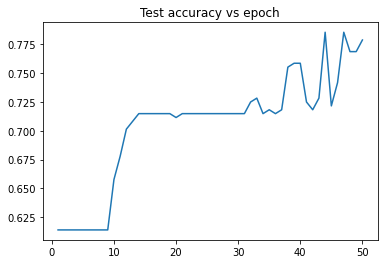

In [ ]:
Epochs = np.arange(1,50+1)

plt.figure()
plt.plot(Epochs, results_LSTM_recovered.history['loss'])
plt.title("Training loss vs epoch")
plt.show()

plt.figure()
plt.plot(Epochs, results_LSTM_recovered.history['accuracy'])
plt.title("Training accuracy vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_LSTM_recovered.history['val_accuracy'])
plt.title("Test accuracy vs epoch")
plt.show()

As you can see in the above, training loss decreases steadily with the number of epochs, but the decrease in training loss becomes very insignificant after epoch=50.

Training accuracy and testing accuracy both increase till epoch=50. However, after that training accuracy increase is neglegable and test accuracy starts to fall, so thats why we chose number of epochs to be 50.

As we calculated in CM3, our LSTM model for the "Recovered" output has: training time=9.26 seconds and its testing time was 0.47 seconds and reached test accuracy of 0.778.

As we expected, the LSTM model has higher training time and testing time since it needs to be trained on sequence of samples and capture the temporal corelations in the data. 

We reached a much better test accuracy with the LSTM network than the default network (0.77 versus 0.61). The LSTM achieved a much better score in the kaggle competition as well.

#Default Network: Deaths Output

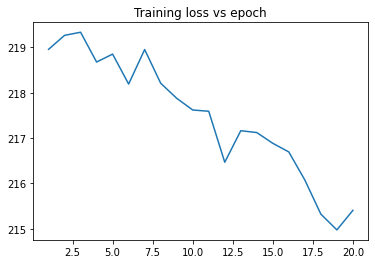

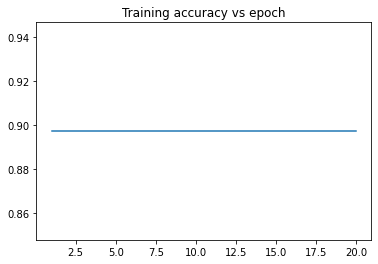

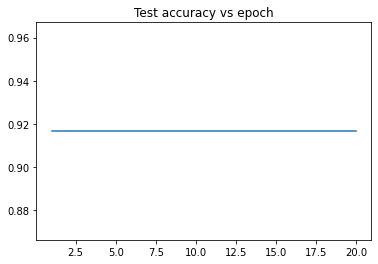

In [ ]:
Epochs = np.arange(1,20+1)

plt.figure()
plt.plot(Epochs, results_default_deaths.history['loss'])
plt.title("Training loss vs epoch")
plt.show()

plt.figure()
plt.plot(Epochs, results_default_deaths.history['accuracy'])
plt.title("Training accuracy vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_default_deaths.history['val_accuracy'])
plt.title("Test accuracy vs epoch")
plt.show()

As you can see in the above, training loss decreases steadily with the number of epochs, but the decrease in training loss becomes very insignificant after epoch=20, so thats why we chose number of epochs to be 20.

Training accuracy and testing accuracy are constant, that means our default model trains very fast and reaches good performance in small number of epochs for this target.

As we calculated in CM2, our default model for the "Recovered" output has 0.629 average cross-validation accuracy, and its training time was 1.317 seconds and its testing time was 0.053 seconds and reached test accuracy of 0.617.

# LSTM Network: Deaths Output

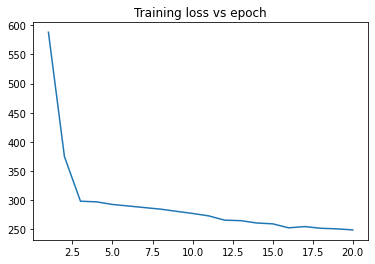

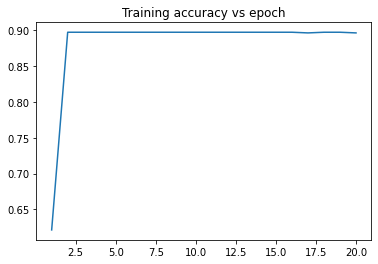

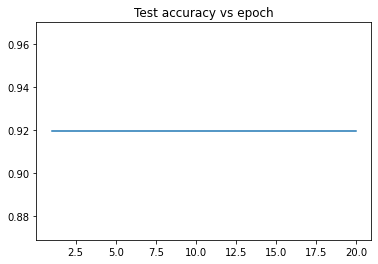

In [19]:
Epochs = np.arange(1,20+1)

plt.figure()
plt.plot(Epochs, results_LSTM_deaths.history['loss'])
plt.title("Training loss vs epoch")
plt.show()

plt.figure()
plt.plot(Epochs, results_LSTM_deaths.history['accuracy'])
plt.title("Training accuracy vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_LSTM_deaths.history['val_accuracy'])
plt.title("Test accuracy vs epoch")
plt.show()

As you can see in the above, training loss decreases with the number of epochs, till epoch=5.

Testing accuracy is constant, and training accuracy becomes constant after epoch=2. That means our default model trains very fast and reaches good performance in small number of epochs for this target. Therefore, we choose number of epochs to be 20.

As we calculated in CM3, our LSTM model for the "Deaths" output has: training time=7.25 seconds and its testing time was 0.50 seconds and reached test accuracy of 0.916.

As we expected, the LSTM model has higher training time and testing time since it needs to be trained on sequence of samples and capture the temporal corelations in the data. We couldn't reach a higher test accuracy than the default model (0.98 is difficult to beat) but for the kaggle competition the output of LSTM model achieved much a better score than the default network.

#Discussion the number of parameters for each model

Number of parameters for the default model = 661

Number of parameters for the LSTM model = 32,451

As evident, the LSTM has higher number of parameters to capture the temporal correlations between instances, and that justifies the longer training and testing time of the LSTM network compared to the simple default architecture.


#CM5

#Kaggle

#Reading and Preprocessing the Kaggle Data 

In [ ]:

df = pd.read_csv('dkmacovid_train.csv')


number_of_rows, _ = df.shape


df_fixed = df['Resident Population 2020 Census'].apply(lambda x: int(''.join(x.split(','))))
dropped = df.drop(columns='Resident Population 2020 Census')
dropped['Resident Population 2020 Census'] = df_fixed
df = dropped.copy()

df_fixed2 = copy.copy(df['Resident Population 2020 Census'])
dropped = df.drop(columns='Population Density 2020 Census')
dropped['Population Density 2020 Census'] = df_fixed_2
df = dropped.copy()



df = df.drop(columns=['Testing_Rate'])
df = df.drop(columns=['Recovered', 'Deaths', 'Confirmed'])




df = df.drop(columns=['Day','State ID', 'State'])

df = df.assign(e=pd.Series(np.random.randn(1380)).values)

scaler = MinMaxScaler()
scaler.fit(df)



df = pd.read_csv('dkmacovid_kaggletest_features.csv')


number_of_rows, _ = df.shape

df_id = df['Id']
df = df.drop(columns=["Id"])

df_fixed = df['Resident Population 2020 Census'].apply(lambda x: int(''.join(x.split(','))))
dropped = df.drop(columns='Resident Population 2020 Census')
dropped['Resident Population 2020 Census'] = df_fixed
df = dropped.copy()

df_fixed2 = copy.copy(df['Resident Population 2020 Census'])
dropped = df.drop(columns='Population Density 2020 Census')
dropped['Population Density 2020 Census'] = df_fixed_2
df = dropped.copy()



df = df.drop(columns=['Testing_Rate'])


df = df.drop(columns=['Day','State ID', 'State'])

df = df.assign(e=pd.Series(np.random.randn(150)).values)
df = scaler.transform(df)


#Using predictions of the trained models to create the prediction csv file

In [ ]:


kaggle_dataset = df

X_kaggle, Y_kaggle = split_sequences(kaggle_dataset, n_steps)

Y_test_Confirmed = model_confirmed.predict(X_kaggle, verbose=0)
Y_test_Deaths = model_deaths.predict(X_kaggle)
Y_test_Recovered = model_recovered.predict(X_kaggle)

thr = 0.5
Y_test_Confirmed[Y_test_Confirmed>thr] = 1
Y_test_Confirmed[Y_test_Confirmed<=thr] = 0


Y_test_Recovered[Y_test_Recovered>thr] = 1
Y_test_Recovered[Y_test_Recovered<=thr] = 0


thr = 0.5

Y_test_Deaths[Y_test_Deaths>thr] = 1
Y_test_Deaths[Y_test_Deaths<=thr] = 0


Y_test_concat = np.concatenate((df_id.to_numpy(dtype='int32')[2:].reshape((148,1)) ,Y_test_Confirmed, Y_test_Deaths, Y_test_Recovered), axis=1)

kaggle_csv = pd.DataFrame(Y_test_concat, columns=['Id','Confirmed','Deaths','Recovered'])



kaggle_csv.index = kaggle_csv.index + 2  # shifting index
kaggle_csv.loc[0] = ['0','1', '1', '1']  # adding a row
kaggle_csv.loc[1] = ['5','1', '1', '1']

kaggle_csv.sort_index(inplace=True) 
kaggle_csv = kaggle_csv.astype({'Id': 'int32'})
kaggle_csv = kaggle_csv.astype({'Confirmed': 'int32'})
kaggle_csv = kaggle_csv.astype({'Deaths': 'int32'})
kaggle_csv = kaggle_csv.astype({'Recovered': 'int32'})

# kaggle_csv.insert(0, {'Id': 0, 'Confirmed': 1, 'Deaths': 1, 'Recovered': 1})
# kaggle_csv.insert(0, {'Id': 5, 'Confirmed': 1, 'Deaths': 1, 'Recovered': 1})



kaggle_csv.to_csv('kaggle_prediction.csv', index=False)



Id           int32
Confirmed    int32
Deaths       int32
Recovered    int32
dtype: object


We save the results in the "kaggle_prediction.csv" file.

We reached score 0.21275. We named our team Group50 in the competition.

#CM6

#Dataset 2: MNIST With a Twist





#Reading and preprocessig the data

In [3]:
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,Activation,Dropout
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import OneHotEncoder

x_train = pd.read_csv('trainX.csv')
x_train.drop('Id', inplace=True, axis=1)
x_train = x_train.to_numpy().reshape(60000, 28,28,1)

y_train = pd.read_csv('trainy.csv')
y_train.drop('Id', inplace=True, axis=1)
y_train = y_train.to_numpy()


x_test = pd.read_csv('testX.csv')
x_test.drop('Id', inplace=True, axis=1)
x_test = x_test.to_numpy().reshape(10000,28,28,1)

y_test = pd.read_csv('testy.csv')
y_test.drop('Id', inplace=True, axis=1)
y_test = y_test.to_numpy()

onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train)
y_test = onehot_encoder.fit_transform(y_test)


As you see above, we read the train and test data, remove feature "Id" from the trainx, and transform the labels using onehot_encoder to perform classification with the softmax output layer and cross-entropy loss function.

#Base-line CNN architecture

In this part, we implement a simple CNN architecture. We used Relu for the convolutional layers and softmax for the output layer. We use padding='same' and stride=1 or stride=2 for the filters in the convolutional layers. The size of the kernel filters are (5,5) or (2,2). We tried different values for learning rate and different optimization function and end up with Adam with lr=0.001.  We tuned these parameters using 20% of the training data as validation data.

You can see the detalied architecture of the base-line model below:

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param   

conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       409728    
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 1285      

Total params: 5,438,917
Trainable params: 5,438,917
Non-trainable params: 0


In [15]:

model = models.Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=(5,5), strides=2, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2),strides=1))
model.add(Conv2D(64, kernel_size=(5,5), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=1))
model.add(Conv2D(128, kernel_size=(5,5), strides=1, padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(5,5), strides=1, padding='same', activation='relu'))
model.add(Flatten())
model.add(layers.Dense(256,activation='relu'))

model.add(layers.Dense(5, activation = "softmax"))

model.summary()

adam = keras.optimizers.Adam(lr=0.001 , amsgrad=False)
epochs = 20

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# train-validation split 
x2_train, x_val, y2_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
results = model.fit(x2_train, y2_train, validation_data=(x_val, y_val),  epochs=epochs)





# training on the whole dataset
start_time = time.time()
results_baseline = model.fit(x_train, y_train, validation_data=(x_test, y_test),  epochs=epochs)

deep_time = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_time)

start_time = time.time()
predicted = model.predict(x_test).argmax(axis=-1)

deep_time = (time.time() - start_time)
print("--- Testing Time %s seconds ---" % deep_time)

expected = y_test.argmax(axis=-1)



          
accuracy = accuracy_score(expected, predicted)

print ("Test accuracy: ",accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 13, 13, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 12, 12, 128)       204928    
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 12, 12, 128)       409728    
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
1500/1500 [==============================] - 12s 7ms/step - loss: 2.3200 - accuracy: 0.6104 - val_loss: 0.5952 - val_accuracy: 0.7542
Epoch 2/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.5701 - accuracy: 0.7555 - val_loss: 0.5641 - val_accuracy: 0.7501
Epoch 3/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.5168 - accuracy: 0.7793 - val_loss: 0.4868 - val_accuracy: 0.8017
Epoch 4/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4757 - accuracy: 0.7990 - val_loss: 0.4589 - val_accuracy: 0.8074
Epoch 5/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4373 - accuracy: 0.8164 - val_loss: 0.4479 - val_accuracy: 0.8117
Epoch 6/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4147 - accuracy: 0.8252 - val_loss: 0.4402 - val_accuracy: 0.8230
Epoch 7/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4040 - accuracy: 0.8327 - val_loss: 0.4075 - val_ac

#Resnet_18 Architecture

To improve performance, we first use the Resnet  architecture that is implemented in the cell code below. We took the code from this github page: https://github.com/raghakot/keras-resnet

The resnet_18 architecture is shown in the figure below:
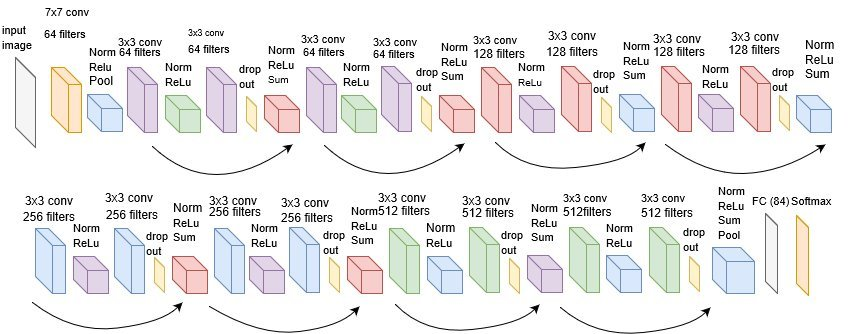

As you can see in the figure, it consits of many convolutional layers and pooling layers and dropout layers and L2-regukazation for improving generalization of the model. The activation function for the convolutional layers are relu and activation function of the output layer after the fully connected layer at the end is softmax. You can see the skip connections in the figure that allows the model to choose the optimal effective depth of the network without worrying about vanishing gradient problem. 

We used the suggested values for the hyper-parameters in the refrence, since it is already optimized for the MNIST dataset. That means batch normalization and dropout after each relu, default adam optimizer and batch_size=32.

#Github code: implementation og Resnet

In [4]:
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    #if K.common.image_dim_ordering()== 'tf':
    ROW_AXIS = 1
    COL_AXIS = 2
    CHANNEL_AXIS = 3
    #else:
        #CHANNEL_AXIS = 1
        #ROW_AXIS = 2
        #COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        #if K.image_dim_ordering() == 'tf':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

# Creating an Resnet_18 instance and training it on our dataset

In [8]:
batch_size = 32
nb_classes = 5
epochs = 50


# input image dimensions
img_rows, img_cols = 28, 28
# The CIFAR10 images are RGB.
img_channels = 1

# The data, shuffled and split between train and test sets:


# Convert class vectors to binary class matrices.
Y_train = y_train
Y_test = y_test

X_train = x_train.astype('float32')
X_test = x_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

start_time = time.time()

results_18 = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test))
          
deep_time = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_time)


start_time = time.time()
predicted = model.predict(X_test).argmax(axis=-1)

deep_time = (time.time() - start_time)
print("--- Testing Time %s seconds ---" % deep_time)

expected = Y_test.argmax(axis=-1)


          
accuracy = accuracy_score(expected, predicted)

print ("Test accuracy: ",accuracy)

Epoch 1/50
1875/1875 [==============================] - 92s 22ms/step - loss: 1.1246 - accuracy: 0.7470 - val_loss: 0.6995 - val_accuracy: 0.8211
Epoch 2/50
1875/1875 [==============================] - 40s 22ms/step - loss: 0.6737 - accuracy: 0.8210 - val_loss: 0.6059 - val_accuracy: 0.8174
Epoch 3/50
1875/1875 [==============================] - 41s 22ms/step - loss: 0.5616 - accuracy: 0.8420 - val_loss: 0.5014 - val_accuracy: 0.8592
Epoch 4/50
1875/1875 [==============================] - 41s 22ms/step - loss: 0.5047 - accuracy: 0.8548 - val_loss: 0.4963 - val_accuracy: 0.8533
Epoch 5/50
1875/1875 [==============================] - 41s 22ms/step - loss: 0.4625 - accuracy: 0.8653 - val_loss: 0.4379 - val_accuracy: 0.8815
Epoch 6/50
1875/1875 [==============================] - 41s 22ms/step - loss: 0.4324 - accuracy: 0.8772 - val_loss: 0.4643 - val_accuracy: 0.8611
Epoch 7/50
1875/1875 [==============================] - 41s 22ms/step - loss: 0.4127 - accuracy: 0.8829 - val_loss: 0.4441 -

# Creating an Resnet_50 instance and training it on our dataset

To further improve performance, we make the resnet model deeper and create an instance of Resnet_50 from the above class from the github refrence. We again use the suggested parameters by the refrence for this model. That means batch normalization and dropout after each relu, default adam optimizer and batch_size=32.

In [9]:


model = ResnetBuilder.build_resnet_50((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

start_time = time.time()
results_50 = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test))

        
deep_time = (time.time() - start_time)
print("--- Training Time %s seconds ---" % deep_time)


start_time = time.time()
predicted = model.predict(X_test).argmax(axis=-1)

deep_time = (time.time() - start_time)

print("--- Testing Time %s seconds ---" % deep_time)

expected = Y_test.argmax(axis=-1)


          
accuracy = accuracy_score(expected, predicted)

print ("Test accuracy: ",accuracy)

Epoch 1/50
1875/1875 [==============================] - 260s 106ms/step - loss: 3.7599 - accuracy: 0.7333 - val_loss: 1.1866 - val_accuracy: 0.8076
Epoch 2/50
1875/1875 [==============================] - 193s 103ms/step - loss: 1.0702 - accuracy: 0.8048 - val_loss: 0.7761 - val_accuracy: 0.8366
Epoch 3/50
1875/1875 [==============================] - 194s 103ms/step - loss: 0.7904 - accuracy: 0.8286 - val_loss: 0.6494 - val_accuracy: 0.8495
Epoch 4/50
1875/1875 [==============================] - 193s 103ms/step - loss: 0.6621 - accuracy: 0.8449 - val_loss: 0.6682 - val_accuracy: 0.8237
Epoch 5/50
1875/1875 [==============================] - 194s 103ms/step - loss: 0.6051 - accuracy: 0.8542 - val_loss: 0.5882 - val_accuracy: 0.8462
Epoch 6/50
1875/1875 [==============================] - 196s 105ms/step - loss: 0.5516 - accuracy: 0.8622 - val_loss: 0.5422 - val_accuracy: 0.8679
Epoch 7/50
1875/1875 [==============================] - 193s 103ms/step - loss: 0.5230 - accuracy: 0.8678 - val_

NameError: ignored

In [11]:
# Ignore the previous error, here instead we repeated the last line of code to get the test accuracy 
accuracy = accuracy_score(expected, predicted)

print ("Test accuracy: ",accuracy)

Test accuracy:  0.8742


In [12]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 14, 14, 64)   3200        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 14, 14, 64)   256         conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation_98 (Activation)      (None, 14, 14, 64)   0           batch_normalization_98[0][0]     
____________________________________________________________________________________________

#CM7

# The base-line approach

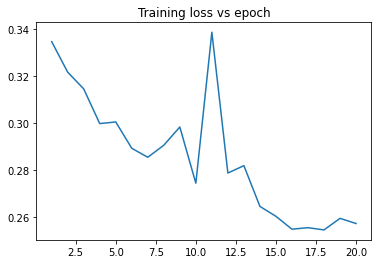

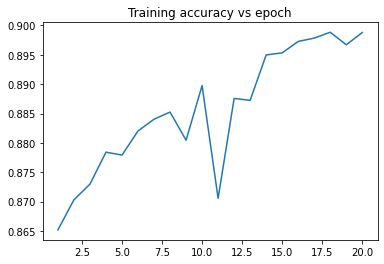

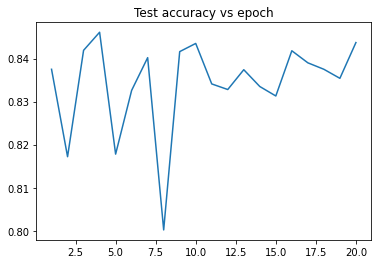

In [17]:
Epochs = np.arange(1,20+1)

plt.figure()
plt.plot(Epochs, results_baseline.history['loss'])
plt.title("Training loss vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_baseline.history['accuracy'])
plt.title("Training accuracy vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_baseline.history['val_accuracy'])
plt.title("Test accuracy vs epoch")
plt.show()

As you can see above, till epoch=20, training loss decreases and training accuracy decreases considrabley. Test accuracy however doesn't seems to exceed 0.4. Therefore, epochs=20 seemed to be a good choice for the small baseline CNN architecture. 

As we calculated in CM6, the baseline CNN approch reaches 0.8437 accuracy on test data with training_time=258.85 seconds and testing_time= 0.70 seconds.

#Resnet_18 Model

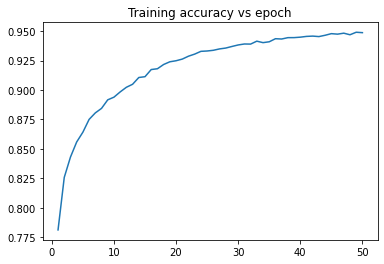

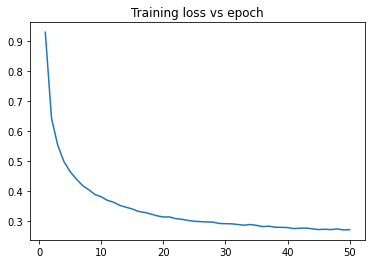

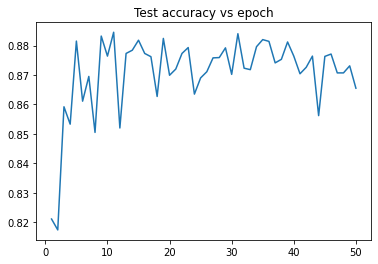

In [13]:
Epochs = np.arange(1,50+1)
plt.figure()
plt.plot(Epochs, results_18.history['accuracy'])
plt.title("Training accuracy vs epoch")
plt.show()

plt.figure()
plt.plot(Epochs, results_18.history['loss'])
plt.title("Training loss vs epoch")
plt.show()

plt.figure()
plt.plot(Epochs, results_18.history['val_accuracy'])
plt.title("Test accuracy vs epoch")
plt.show()

For the resnet_18 model, training loss decraeses steadily with higher epochs and training accuracy stictly increase till epochs=50. The test accuracy however flunctuates a little bit around 0.87 as number of epochs increases. Therefore, any number of epochs between 10 to 50 would be suitable for this model.

As we calculated in CM6, the Resnet_18 model reaches 0.87 accuracy on test data with training_time=2145 seconds and testing_time= 2.95 seconds. Even though it takes so much more time to train the resnet model compared to the baseline as it is deeper with many more trainable variables, its accuracy is 3% or 4% higher on test data. This increase in accuracy couldn't be achieved in many trials of different configuration of the baseline method.

#Resnet_50 Model

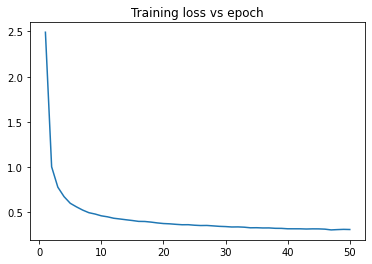

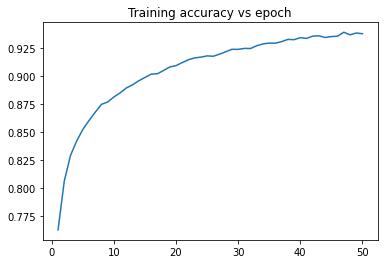

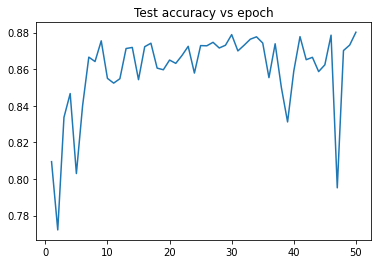

In [14]:
Epochs = np.arange(1,50+1)

plt.figure()
plt.plot(Epochs, results_50.history['loss'])
plt.title("Training loss vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_50.history['accuracy'])
plt.title("Training accuracy vs epoch")
plt.show()


plt.figure()
plt.plot(Epochs, results_50.history['val_accuracy'])
plt.title("Test accuracy vs epoch")
plt.show()

For the resnet_18 model, training loss decraeses steadily with higher epochs and training accuracy stictly increase till epochs=50. The test accuracy however flunctuates a little bit around 0.87 as number of epochs increases. Therefore, any number of epochs between 10 to 50 would be suitable for this model.

As we calculated in CM6, the Resnet_18 model reaches 0.88 accuracy on test data with training_time=9833 seconds and testing_time= 9.79 seconds. Its training time and test time is 5 times more than Resnet_18 but it didn't receive a very better accuracy on test data, therefore, probably it is best to choose the Resnet_18 for this dataset.

#Discussion the number of parameters for each model

Number of parameters for the baseline model = 1,664

Number of parameters for the Resnet_18 model (trainable) = 11,175,813

Number of parameters for the Resnet_50 model (trainable) = 23,530,885

It's obvious that the Resnet models are much deeper networks with many more parameters and that justifies the higher training/testing time of these models. However, becasue of the skip connections the training of the resnet models is lower relative to the very high number of parameters.